 # Make sure to install tensorflow and keras library first. 
 I have used dsvm out of the box as it comes with most of the packages needed for this exercise. it gives a really good starting point. it had pandas, numpy, python, sql management studio, teams and several other packages installed so all i had to do was to create a DSVM and then login to the box. Start a jupyter notebook and start coding away.

In [45]:
#conda install tensorflow

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array,load_img,array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
import PIL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests

   ### Check the version of the tensorflow and make sure its 2 or above. 


In [4]:
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


### Download training data
The data used in this exercise is from kaggle. Link for this data is [here(https://www.kaggle.com/c/dog-breed-identification/data)] After downloading make sure to **change** the path below so the path is relative to this notebook.



In [5]:
alldata = pd.read_csv('../../../Downloads/dog-breed-identification/labels.csv')
alldata.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


Code below reads the unique breeds from the data and creates an extra column creating a unique number for each breed. This number will then be used to **one-hot encode** the labels. Also same file will be used again to find the breed name again once the model predicts the breed. I have picked the number 120 below as based on quick data profiling and documentation on kaggle i know it has data for 120 unique breeds. This step can take **long time** as it is reading entire set of images and creating x and y labels for all the data.

In [6]:
allbreeds = pd.DataFrame(data = alldata.breed.unique(), columns=['breed'])
breednumber = pd.DataFrame(pd.RangeIndex(120),columns=['breednum'])
allbreeds = allbreeds.join(breednumber)

alldatanew = alldata.merge(allbreeds, on='breed',)
alldatanew
ally = np.array([x for x in alldatanew['breednum'].values])
allx =np.array([img_to_array(load_img('../../../Downloads/dog-breed-identification/train/{0}.jpg'.format(x), target_size=(299,299))) for x in alldatanew['id'].values])

Check the size of the data to make sure we get **299, 299 RGB** images. 

In [7]:
print(allx.shape)
print(ally.shape)

(10222, 299, 299, 3)
(10222,)


### Split the dataset into training and test data. 
I picked 20 percent of the data to test on. Since we have 85 ish images per breed. it will create roughly 70ish images to train on and 15ish images to test on. 

In [8]:
x_train, x_val, y_train, y_val = train_test_split(allx, ally,  test_size=0.20, random_state=12)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(8177, 299, 299, 3)
(8177,)
(2045, 299, 299, 3)
(2045,)


### Use of keras imagedatagenerator 
This will generate more images and make my training set even more complex. it will shear the image, change the zoom, flip it horizontally, vertically etc. You can experiment and remove few and see how your model behaves. Also it is scaling the images by dividing by 255. On the validation/test dataset i am not messing with the image and you will see when we train model will have harder time fit on training data whereas it will start fitting on test data much faster. 

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
                        )
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

### Create vectors for label. 
Below code converts the label numbers to vectors of 0, except whichever class is true there will one at that index. e.g. if a dog is weimeraner and its assigned number 5. it will be represented as a vector of 120 0s and there will be 1 at 5th position. it will change the dimension of label from (number of samples) to (number of samples, number of classes)

In [12]:
print(y_val.shape)
print(y_train.shape)
y_val_oh = tf.keras.utils.to_categorical(y_val)
y_train_oh = tf.keras.utils.to_categorical(y_train)
y_train_oh = np.array(y_train_oh, dtype=int)
y_val_oh = np.array(y_val_oh, dtype=int)
print(y_val_oh.shape)
print(y_train_oh.shape)


(2045,)
(8177,)
(2045, 120)
(8177, 120)


### Saving the breed name to number mapping.
this breed name to number mapping will be used later to convert the predicted breed number to its name which will be served through api.

In [13]:
#from sklearn import preprocessing
#lb = preprocessing.LabelBinarizer()
alldatanew.to_csv("mydata.csv")
#y_train_oh = lb.fit_transform(y_train)
#y_val_oh = lb.fit_transform(y_val)
print(y_val.shape)
print(y_train.shape)
print(y_train_oh.shape)
print(y_val_oh.shape)

(2045,)
(8177,)
(8177, 120)
(2045, 120)


### Final check before we start training
Below code can be used to spot check we did not mess up anything while creating the training vectors from the data. Check few indexes to make sure it matches with the downloaded data still.

       breed  breednum
62  komondor        62


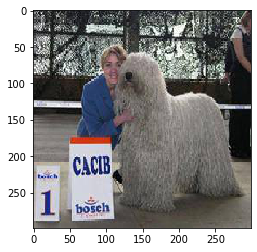

In [27]:
indextocheck = 2
plt.imshow(array_to_img(x_train[indextocheck]))
breednumber = np.argmax(y_train_oh[indextocheck],axis=0)
print(allbreeds[allbreeds['breednum'] == breednumber])

### Train and test data generators.
The below code will simply take the training and test vectors and feed to the model for training. .flow has a mthod from directory which is specially useful if you have images in folders where each folder is a single class. You just have to give it the parent folder and it will create label etc. from the data itself.

In [28]:
train_generator = train_datagen.flow(x_train, y_train_oh, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val_oh, batch_size=64)

### Transfer learning from InceptionV3

This is where you get to play with which model to pick to start from. Various other companies have trained the models with ***TONS*** of images and published the weights. We will use the model as is and add few layers on which we will train our model on. 

In [31]:
baseInception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
baseInception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

### Customizing the model to our needs.
As you can see the model has 21M parameters. We will use all the payers and freeze them or make the untrainable. Then add a training layer of 512 units and a final layer of 120 as a softmax layer to do the prediction.You can see after this the trainable parameters will be way less.

In [35]:
lastlayer = baseInception.output
d1 = tf.keras.layers.GlobalAveragePooling2D()(lastlayer)
d2 = tf.keras.layers.Dense(512, activation='relu')(d1)
output = tf.keras.layers.Dense(120, activation='softmax')(d2)
model = tf.keras.Model(inputs = baseInception.input, outputs = output)
for layer in baseInception.layers:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

### Compile the model
Below code compiles the model using adam optimizer. There are several other out of the box like SGD etc. which can be used here. Also we can pick a learning rate and experiment with it. If the model does not train well, you can use the callbacks to reduce the learning rate as it gets more and more better.

In [36]:
model.compile(tf.keras.optimizers.Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model (GPU needed)
This is where we would need a GPU. Up until now all the code can be easily done on a CPU or even your local machine. But to train this model we woudl need GPU. I was able to spin up a NC machine in azure just for this purpose. Once you are done training you can just shut it down and do all the other work on your own laptop or CPU.

In [37]:
history = model.fit(x=train_generator, epochs=30, validation_data=val_generator,verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128 steps, validate for 32 steps
Epoch 1/30
128/128 [==============================] - 727s 6s/step - loss: 3.4555 - accuracy: 0.3114 - val_loss: 0.9728 - val_accuracy: 0.7892
Epoch 2/30
128/128 [==============================] - 720s 6s/step - loss: 1.9149 - accuracy: 0.5421 - val_loss: 0.5746 - val_accuracy: 0.8352
Epoch 3/30
128/128 [==============================] - 722s 6s/step - loss: 1.5879 - accuracy: 0.5899 - val_loss: 0.5065 - val_accuracy: 0.8553
Epoch 4/30
128/128 [==============================] - 724s 6s/step - loss: 1.4131 - accuracy: 0.6244 - val_loss: 0.4698 - val_accuracy: 0.8670
Epoch 5/30
128/128 [==============================] - 719s 6s/step - loss: 1.3123 - accuracy: 0.6439 - val_loss: 0.4697 - val_accuracy: 0.8597
Epoch 6/30
128/128 [==============================] - 719s 6s/step - loss: 1.2423 - accuracy: 0.6639 - val_loss: 0.4726 - val_accuracy: 0.8533
Epoch 7/30
128/128 [=============================

### Save the trained model
Below code saves the model with its architecture and the weights. we can use it later for loading in azure ML and then create services using it. You can also save the history of saving for checking later on how training went.

In [41]:
model.save('mytrainedInception0413_final.h5')
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'historyInception0413.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

    

### Plot the training and validation accuracy
You will see that since we had made our training data so much more complicated then validation data, model started performing really well on test data because we used transfer learning. 


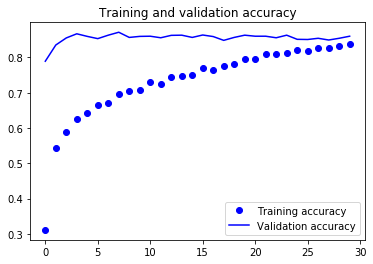

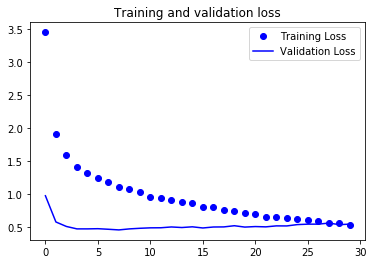

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### More training/Prediction
Below code shows how to start training once model has trained a little and you want to restart from that point on. Then sample below shows how to use it to do prediction. We will do this part in a seperate exercise where we will deploy the model to ACI and then call it from a service.

In [88]:
history = model.fit(x=train_generator, epochs=75, validation_data=val_generator,verbose=1, initial_epoch = 25)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 256 steps, validate for 64 steps
Epoch 26/75
256/256 [==============================] - 726s 3s/step - loss: 0.8806 - accuracy: 0.7394 - val_loss: 0.5176 - val_accuracy: 0.8489
Epoch 27/75
120/256 [=============>................] - ETA: 5:47 - loss: 0.8316 - accuracy: 0.7495

KeyboardInterrupt: 

In [78]:
model.save('mytrainedInception0413.h5')


In [2]:
newmodel = tf.keras.models.load_model('mytrainedInception0413.h5')

In [3]:
newmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [94]:
predictontrain = newmodel.predict(x_train[0:30]/255)




In [95]:
predictontrain.shape

(30, 120)

In [13]:
mappingdata = pd.read_csv('mydata.csv')

In [14]:
mappingdata.head(5)

,Unnamed: 0,id,breed,breednum
0,0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,1,010d65bd29d246aea53d9849da142ccf,boston_bull,0
2,2,0755a940eac9a9b8cf0328b4be062096,boston_bull,0
3,3,07d7cfbdbd3682cae50902b53c798028,boston_bull,0
4,4,0b3d3120a62c2bc280f589d473041d06,boston_bull,0


In [96]:
t1 = np.argmax(predictontrain,axis=1)
t1

array([ 54, 101,  62,  88,  13,  44, 108,  59,  60,  56,  70,  97,  41,
       116,  80, 113,  40,  51, 100,  89, 115,  54, 102,  23,  55,  97,
       107,  27,  92,  89], dtype=int64)

In [127]:
mappingbreedtonum = mappingdata[['breed','breednum']]
deduped = mappingbreedtonum.drop_duplicates()
deduped.set_index('breednum', inplace=True)
deduped

,breed
breednum,
0,boston_bull
1,dingo
2,pekinese
3,bluetick
4,golden_retriever
...,...
115,bouvier_des_flandres
116,tibetan_mastiff
117,english_springer


In [126]:
t1 = deduped
t1.set_index('breednum', inplace=True)
t1.iloc[0].values[0]

'boston_bull'

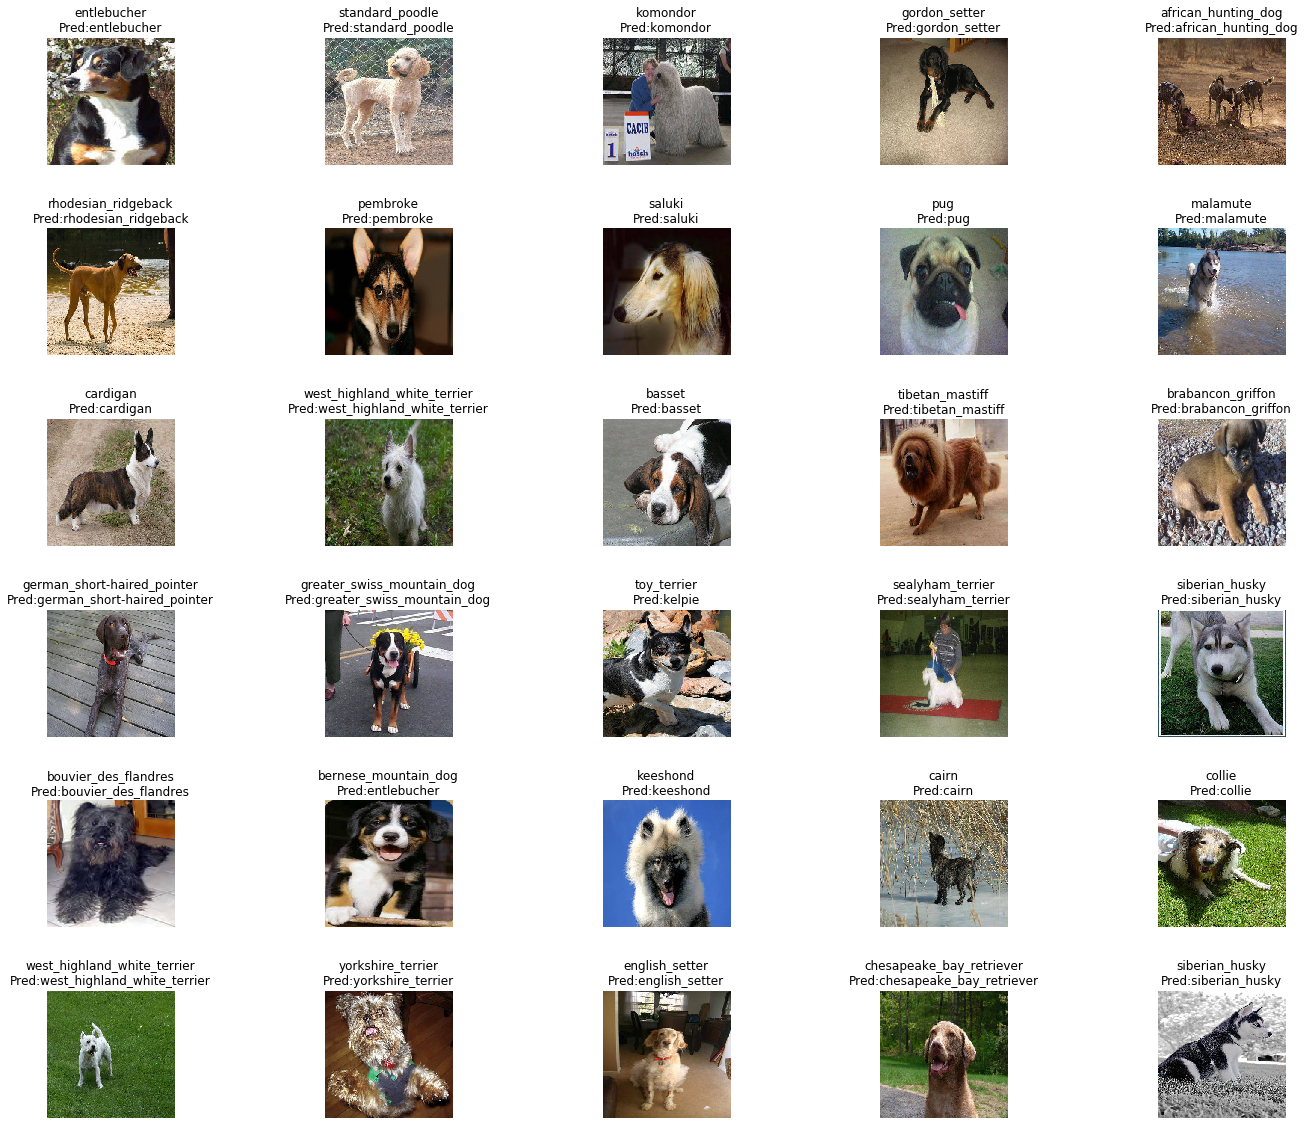

In [137]:
t1 = np.argmax(predictontrain,axis=1)
#print(t1)
#print(y_train[0:30])
trainandpredict = np.stack((t1, y_train[0:30]), axis=0)
trainandpredict.shape
transposed = np.transpose(trainandpredict)
breeddf = pd.DataFrame(transposed, columns=['predictedbreednum', 'actualbreednum'])


f, ax = plt.subplots(6,5)
f.set_size_inches(18,15)
counter = 0
for i in range(0,6):
    for j in range(0,5):
         actualy = y_train[counter]
         #print(actualy)
         preductedy = t1[counter]
         #print(preductedy)
         actualyname = deduped.iloc[actualy].values[0]
         predictedname = deduped.iloc[preductedy].values[0]
         ax[i][j].axis('off')
         ax[i][j].set_title(actualyname + '\nPred:' + predictedname )
         ax[i][j].imshow(array_to_img(x_train[counter]))
         counter += 1

plt.subplots_adjust(left=0, bottom = 0, right=1, top=1, wspace=0.5, hspace=0.5)



In [160]:
def predict(filename):
    img = load_img(filename, target_size =(299,299))
    #plt.imshow(img)
    imgarray = img_to_array(img)
    #print(imgarray.shape)
    imgarray = imgarray/255
    imgarray = imgarray.reshape(1,299,299,3)
    #print(imgarray.shape)
    prediction =  newmodel.predict(imgarray)
    breednum = np.argmax(prediction,axis=1)
    #print(breednum)
    #print(breednum[0])
    breedname =  deduped.iloc[breednum[0]].values[0]
    return breedname
    

In [168]:
odinpredict = predict('odinnow.jpg')
odinpredict

(299, 299, 3)
(1, 299, 299, 3)
[80]
80


'brabancon_griffon'

In [169]:
tf.keras.__version__

'2.2.4-tf'

In [175]:
t1 = np.array(['sdfds','sdfdsfds'], dtype='U25')
t1

array(['sdfds', 'sdfdsfds'], dtype='<U25')

In [176]:
newmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
activation_106 (Activation)     (None, 35, 35, 64)   0           batch_normalization_106[0][0]    
__________________________________________________________________________________________________
activation_108 (Activation)     (None, 35, 35, 64)   0           batch_normalization_108[0][0]    
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 35, 35, 96)   0           batch_normalization_111[0][0]    
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 35, 35, 64)   0           batch_normalization_112[0][0]    
__________________________________________________________________________________________________
mixed1 (Concatenate)            (None, 35, 35, 288)  0           activation_106[0][0]             
          

batch_normalization_129 (BatchN (None, 17, 17, 128)  384         conv2d_129[0][0]                 
__________________________________________________________________________________________________
activation_129 (Activation)     (None, 17, 17, 128)  0           batch_normalization_129[0][0]    
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 17, 17, 128)  98304       mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 17, 17, 128)  114688      activation_129[0][0]             
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 17, 17, 128)  384         conv2d_125[0][0]                 
__________________________________________________________________________________________________
batch_norm

batch_normalization_149 (BatchN (None, 17, 17, 160)  480         conv2d_149[0][0]                 
__________________________________________________________________________________________________
activation_149 (Activation)     (None, 17, 17, 160)  0           batch_normalization_149[0][0]    
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 17, 17, 160)  122880      mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 17, 17, 160)  179200      activation_149[0][0]             
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 17, 17, 160)  480         conv2d_145[0][0]                 
__________________________________________________________________________________________________
batch_norm

batch_normalization_165 (BatchN (None, 8, 8, 320)    960         conv2d_165[0][0]                 
__________________________________________________________________________________________________
batch_normalization_169 (BatchN (None, 8, 8, 192)    576         conv2d_169[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 8, 8, 320)    0           batch_normalization_165[0][0]    
__________________________________________________________________________________________________
activation_169 (Activation)     (None, 8, 8, 192)    0           batch_normalization_169[0][0]    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 8, 8, 768)    0           mixed7[0][0]                     
__________________________________________________________________________________________________
mixed8 (Co

batch_normalization_186 (BatchN (None, 8, 8, 384)    1152        conv2d_186[0][0]                 
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 8, 8, 192)    393216      average_pooling2d_17[0][0]       
__________________________________________________________________________________________________
batch_normalization_179 (BatchN (None, 8, 8, 320)    960         conv2d_179[0][0]                 
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 8, 8, 384)    0           batch_normalization_181[0][0]    
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 8, 8, 384)    0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
activation

In [180]:
import pickle
from sklearn.externals import joblib
joblib.dump(newmodel,'mymodeljoblib')

TypeError: can't pickle _thread.RLock objects

In [89]:
import json
import base64
import requests
scoring_uri = "http://c262f513-c506-4082-9a6a-3632c2a9ea17.uksouth.azurecontainer.io/score"
headers = {'Content-Type':'application/json'}


data = {}
with open('../../../Downloads/dog-breed-identification/train/bf5a837a9050a1dc1fd43027f99c9b7b.jpg', mode='rb') as file:
    img = file.read()
data['imagestr'] = base64.encodebytes(img).decode("utf-8")

#print(json.dumps(data))
response = requests.post(scoring_uri, json.dumps(data), headers=headers)
print (response.content)
print((json.loads(response.content))['result'])


b'{"result": "[4]"}'
[4]


In [58]:
def run(data):
    try:
        #mappingdata = pd.read_csv('mydata.csv')
        #mappingbreedtonum = mappingdata[['breed','breednum']]
        #deduped = mappingbreedtonum.drop_duplicates()
        #deduped.set_index('breednum', inplace=True)
        data = json.loads(data)
        f = io.BytesIO(base64.b64decode(data['imagestr']))
        pilimage = Image.open(f)
        pilimage = pilimage.resize((299,299))
        imagearr = img_to_array(pilimage)
        data1 = np.zeros((299,299,3))
        imgarray = imagearr/255
        imgarray = imgarray.reshape(1,299,299,3)
        prediction =  model.predict(imgarray)
        breednum = np.argmax(prediction,axis=1)
        #breedname =  deduped.iloc[breednum[0]].values[0]
        return {"result": str(breednum)}
        #return data
        # You can return any data type, as long as it is JSON serializable.

    except Exception as e:
        error = str(e)
        return error

TypeError: Object of type bytes is not JSON serializable

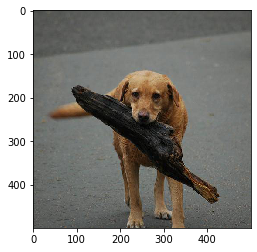

In [26]:
import base64
import requests
headers={'Content-type':'application/json', 'Accept':'application/json'}
url = "http://00b87835-77ae-40fa-8265-6d2c58a88a9e.uksouth.azurecontainer.io/score" 
with open("../../../Downloads/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg", "rb") as imageFile:
    str = base64.b64encode(imageFile.read())
    f = io.BytesIO(base64.b64decode(str))
    pilimage = Image.open(f)
    plt.imshow(pilimage)
    data = {"data": str}
    response = requests.post(url, json = data,headers=headers)
    print(response.status_code)
    print(response.content)

(299, 299, 3)


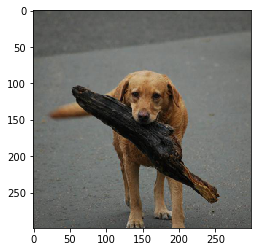

In [27]:
from PIL import Image
import io

f = io.BytesIO(base64.b64decode(str))
pilimage = Image.open(f)
pilimage = pilimage.resize((299,299))
imagearr = img_to_array(pilimage)
print(imagearr.shape)
plt.imshow(pilimage)